In [1]:
import copy
from astropy.coordinates import SkyCoord
import astropy.constants as const
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

HI_restfreq = 1420405751.0 * u.Hz

In [2]:
# Function to average the two polarizations together and return a fits HDU object with the same header
def avg_pol(file):
    stokesI = np.mean(file[0].data,axis=0)
    new_file = fits.PrimaryHDU(data=stokesI,header=file[0].header)
    return new_file

In [3]:
# Function to make a mom0 map with the option to clip at a given sigma value.
# If the grid is an 'a' grid, only make a mom0 using the low frequency portion of the grid.
# Returns a 2-d array.

# *** NOT USED IN THIS NOTEBOOK, BUT SAVED FOR POSTERITY AS AN ALTERNATIVE ***
def simp_mom0(file,sigma=False):

    rms = np.sqrt(np.mean(np.square(file.data[300].flatten())))
    
    if file.header['CRVAL3'] > 1400:  # hopefully catches all "a" grids and not the others.
        if sigma:
            blanked_cube = np.where(np.abs(file.data[0:550]) > sigma*rms, file.data[0:550], 0.)
            mom0 = np.sum(blanked_cube,axis=0)
        else:
            mom0 = np.sum(file.data[0:550,:,:],axis=0)
        print("I think this is a grid a")
    else:
        if sigma:
            blanked_cube = np.where(np.abs(file.data) > sigma*rms, file.data, 0.)
            mom0 = np.sum(blanked_cube,axis=0)
        else:
            mom0 = np.sum(file.data,axis=0)
        print("grid b,c, or d")
    
    return mom0

In [4]:
# Function to make a mom8 map with the option to clip at a given sigma value.  Mom8 is the max value along freq axis.
# If the grid is an 'a' grid, only make a mom0 using the low frequency portion of the grid.
# Returns a 2-d array.

def simp_mom8(file,sigma=False):

    rms = np.sqrt(np.mean(np.square(file.data[300].flatten())))
    
    if file.header['CRVAL3'] > 1400:  # hopefully catches all "a" grids and not the others.
        mom8 = np.max(file.data[0:550,:,:],axis=0)
    else:
        mom8 = np.max(file.data,axis=0)
    
    return mom8

In [5]:
# Function to calculate the frequency associated with a velocity.  Both are in the heliocentric frame.
def vhelio2freq(vhelio):
    z = vhelio * u.km/u.s / const.c
    freq = HI_restfreq/(1+z)
    return freq.decompose().to(u.Hz)

In [7]:
# Read in the data cube
grida_hdu = fits.open('../A2010/pipeline.unknown_date/1044+13a_spectral.fits')
gridb_hdu = fits.open('../A2010/pipeline.unknown_date/1044+13b_spectral.fits')
gridc_hdu = fits.open('../A2010/pipeline.unknown_date/1044+13c_spectral.fits')
gridd_hdu = fits.open('../A2010/pipeline.unknown_date/1044+13d_spectral.fits')

In [16]:
# Read in the weights cube
wgtsa_hdu = fits.open('../A2010/pipeline.unknown_date/1044+13a_spectralweights.fits')
wgtsb_hdu = fits.open('../A2010/pipeline.unknown_date/1044+13b_spectralweights.fits')
wgtsc_hdu = fits.open('../A2010/pipeline.unknown_date/1044+13c_spectralweights.fits')
wgtsd_hdu = fits.open('../A2010/pipeline.unknown_date/1044+13d_spectralweights.fits')

In [17]:
# Normalize the data by the weights
grida_norm = copy.deepcopy(grida_hdu)
gridb_norm = copy.deepcopy(gridb_hdu)
gridc_norm = copy.deepcopy(gridc_hdu)
gridd_norm = copy.deepcopy(gridd_hdu)
grida_norm[0].data = grida_norm[0].data * wgtsa_hdu[0].data / np.max(wgtsa_hdu[0].data)
gridb_norm[0].data = gridb_norm[0].data * wgtsb_hdu[0].data / np.max(wgtsb_hdu[0].data)
gridc_norm[0].data = gridc_norm[0].data * wgtsc_hdu[0].data / np.max(wgtsc_hdu[0].data)
gridd_norm[0].data = gridd_norm[0].data * wgtsd_hdu[0].data / np.max(wgtsd_hdu[0].data)

In [10]:
# Get the spatial wcs information
alfalfa_wcs = WCS(grida_hdu[0].header,naxis=2)

In [11]:
# Optional: plot the location of the galaxies
# COMMENT OUT, or don't runs cell if not plotting galaxies
durb1 = Table.read('../A2010/durbala2020-table1.21-Sep-2020.fits.gz')
durb2 = Table.read('../A2010/durbala2020-table2.21-Sep-2020.fits.gz')
durb1_coord = SkyCoord(durb1['RA'],durb1['DEC'],unit='deg')

<Figure size 640x480 with 0 Axes>

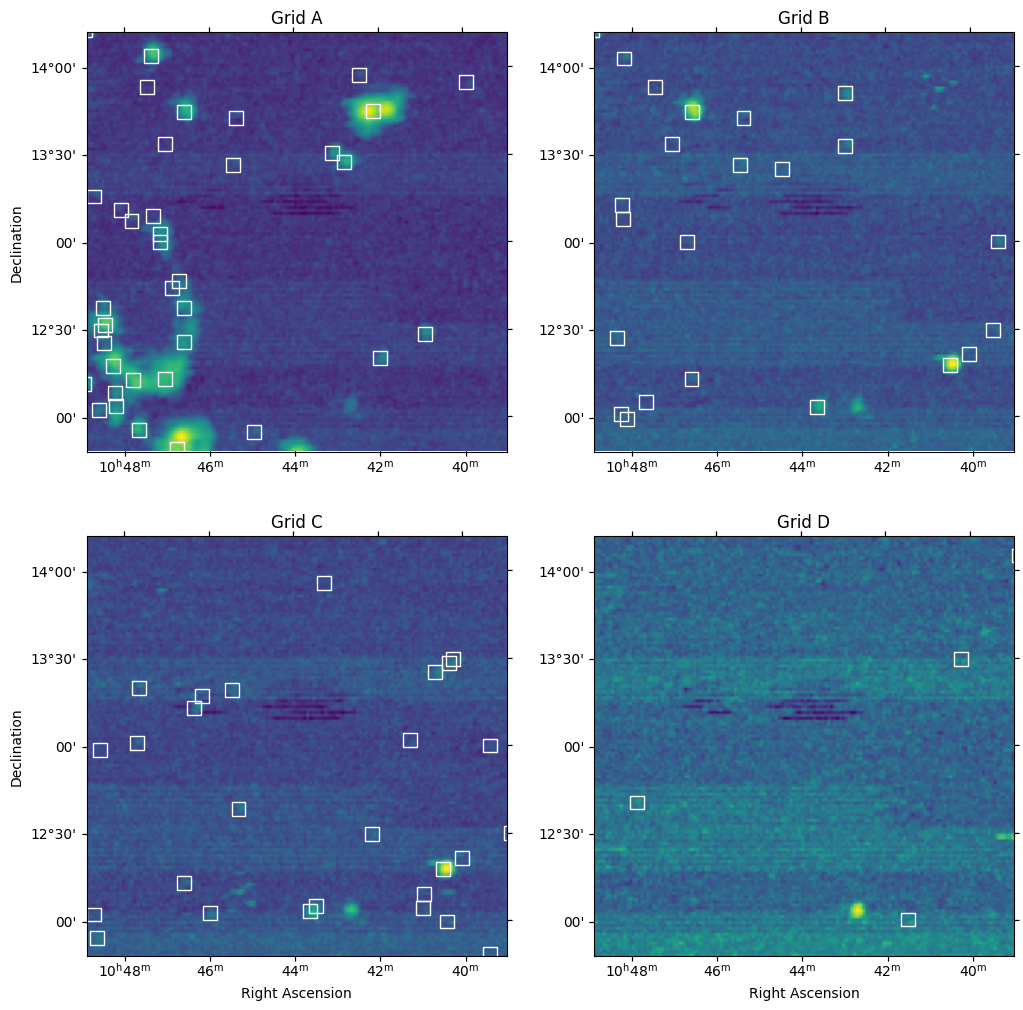

In [34]:
#

fig = plt.figure()
fig_im, ax_im = plt.subplots(2, 2, figsize=(12,12), subplot_kw={'projection': alfalfa_wcs}, squeeze=False)

durb1_freq = vhelio2freq(durb1['Vhelio'])

i,j,k = 0,0,0
for g,l in zip([grida_norm,gridb_norm,gridc_norm,gridd_norm],['Grid A','Grid B','Grid C','Grid D']):        
    grid = avg_pol(g)
    mom8 = simp_mom8(grid)
    fmin,fmax = g[0].header['CRVAL3'],g[0].header['CRVAL3']+g[0].header['CDELT3']*g[0].header['NAXIS3'] # COMMENT OUT IF NOT PLOTTING GALS
    durb1_subset = durb1_coord[(durb1_freq > fmin*u.MHz) & (durb1_freq < fmax*u.MHz)]                   # COMMENT OUT IF NOT PLOTTING GALS
    if i == 0:
        all_mom8 = mom8
    else:
        all_mom8 = np.concatenate((all_mom8,mom8))
    k = i
    if i >= 2:
        j,k = 1,i-2
    im = ax_im[j,k].imshow(mom8,norm=colors.LogNorm())
    ax_im[j,k].autoscale(False)
    ax_im[j,k].scatter_coord(durb1_subset,marker='s',color='white',facecolor='none',s=100)              # COMMENT OUT IF NOT PLOTTING GALS
    ax_im[j,k].set_title(l)
    if j==0:
        ax_im[j,k].coords[0].set_axislabel('')
        # ax_im[j,k].coords[0].set_ticklabel_visible(False)
    else:
        ax_im[j,k].coords[0].set_axislabel('Right Ascension')
    if k>=1:
        ax_im[j,k].coords[1].set_axislabel('')
        # ax_im[j,k].coords[1].set_ticklabel_visible(False)
    else:
        ax_im[j,k].coords[1].set_axislabel('Declination')
    i+=1
all_mom8 = all_mom8.reshape(4,-1,np.shape(all_mom8)[-1])
all_mom8 = np.max(all_mom8, axis=0)

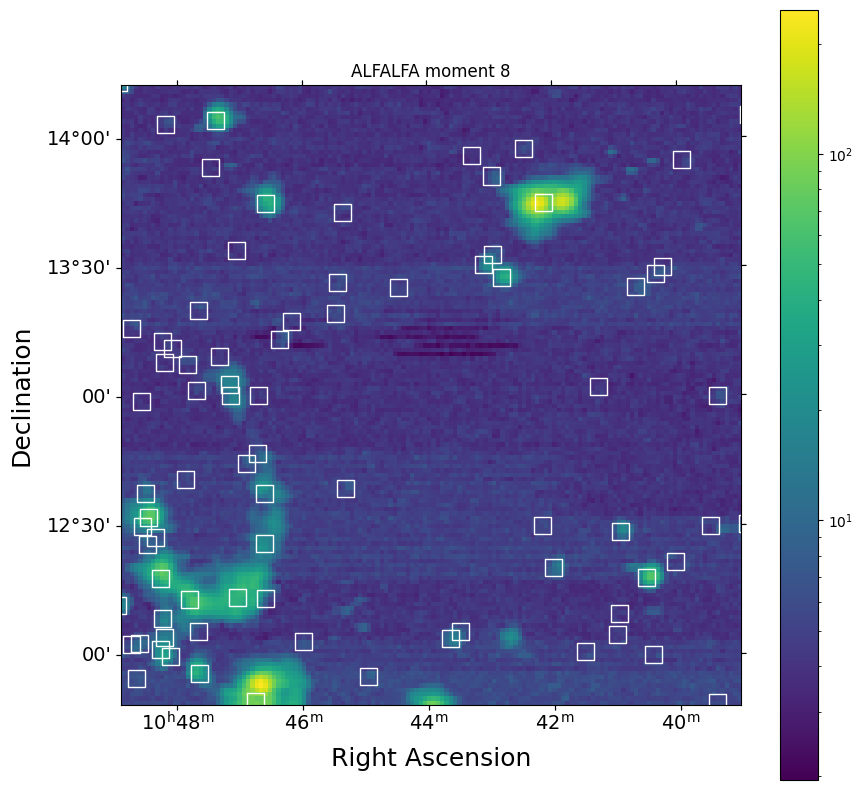

In [42]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=alfalfa_wcs)
im = ax.imshow(all_mom8,norm=colors.LogNorm())
ax.autoscale(False)
ax.scatter_coord(durb1_coord,marker='s',color='white',facecolor='none',s=150)
ax.coords[0].set_axislabel('Right Ascension',fontsize=18)
ax.coords[1].set_axislabel('Declination',fontsize=18)
ax.coords[0].set_ticklabel(size=14)
ax.coords[1].set_ticklabel(size=14)
ax.set_title('ALFALFA moment 8')
fig.colorbar(im)